In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils

In [2]:
# Load data and preprocess images (as you provided)
labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
X = []
y = []

image_size = 224

for i in labels:
    folderPath = os.path.join('Tumor1/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

X = np.array(X)
y = np.array(y)

100%|████████████████████████████████████████| 793/793 [00:00<00:00, 895.36it/s]


In [3]:
from sklearn.preprocessing import LabelEncoder
# Perform label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [4]:
from sklearn.model_selection import train_test_split
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.10, random_state=42)

In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [6]:
from tensorflow.keras.utils import to_categorical
# Convert integer labels to one-hot encoded vectors
y_train_onehot = to_categorical(y_train, num_classes=len(labels))
y_val_onehot = to_categorical(y_val, num_classes=len(labels))

In [7]:
#build the model
Xception = Xception(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))

model = Xception.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(6, activation='softmax')(model)
model = Model(inputs=Xception.input,
              outputs=model)

#get summary()
model.summary()

2023-08-29 17:34:33.989326: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-08-29 17:34:33.989350: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-29 17:34:33.989356: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-29 17:34:33.989385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-29 17:34:33.989400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


83683744/83683744 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [8]:
#compile model
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define checkpoint
checkpoint = ModelCheckpoint('model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [9]:
batch_size = 32
epochs = 30

#train the model
history = model.fit(datagen.flow(X_train, y_train_onehot, batch_size=batch_size),
    validation_data=(X_val, y_val_onehot),
    epochs=epochs,verbose=1,callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/30


2023-08-29 17:34:58.111689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


207/207 [==============================] - ETA: 0s - loss: 0.3963 - accuracy: 0.8727

2023-08-29 17:36:52.454964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.59103, saving model to model.h5


/Users/abi/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - 120s 554ms/step - loss: 0.3963 - accuracy: 0.8727 - val_loss: 2.0732 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 2/30
207/207 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9374
Epoch 2: val_accuracy improved from 0.59103 to 0.94022, saving model to model.h5
207/207 [==============================] - 114s 548ms/step - loss: 0.1964 - accuracy: 0.9374 - val_loss: 0.2183 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 3/30
207/207 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9488
Epoch 3: val_accuracy did not improve from 0.94022
207/207 [==============================] - 113s 544ms/step - loss: 0.1542 - accuracy: 0.9488 - val_loss: 0.4680 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 4/30
207/207 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9621
Epoch 4: val_accuracy did not improve from 0.94022

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
207/207 

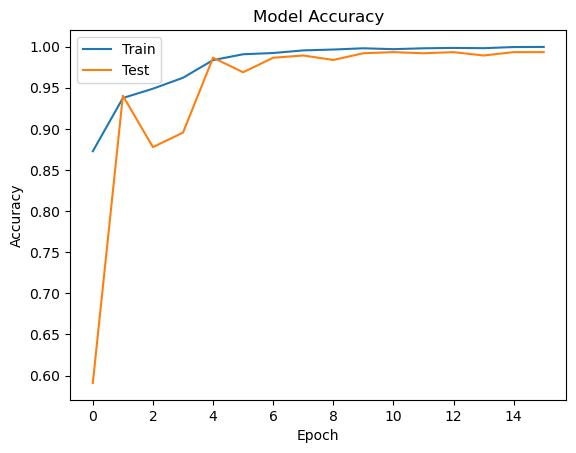

In [10]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

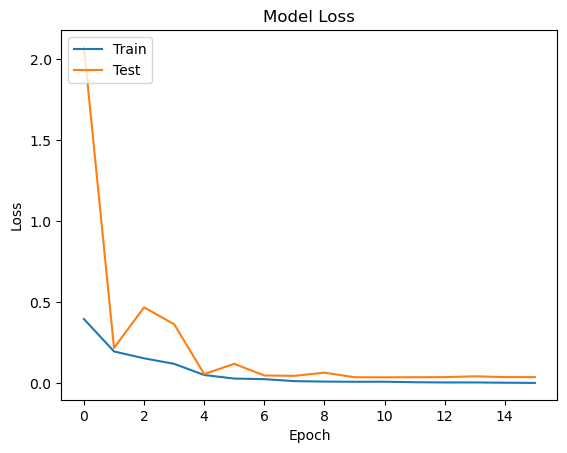

In [11]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
# Save the trained model in SavedModel format
from tensorflow.keras.models import load_model, save_model
model.save('Xception(99%).h5')


In [ ]:
model = load_model('Xception(99%).h5')

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(X_train, y_train_onehot)
print(f"Training Loss: {loss:.4f}, Training Accuracy: {accuracy:.4f}")

2023-08-29 18:08:18.117666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


207/207 [==============================] - 35s 166ms/step - loss: 0.0015 - accuracy: 0.9994
Training Loss: 0.0015, Training Accuracy: 0.9994


In [14]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val_onehot)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

23/23 [==============================] - 4s 165ms/step - loss: 0.0383 - accuracy: 0.9932
Validation Loss: 0.0383, Validation Accuracy: 0.9932


In [15]:
# # Make predictions
# y_pred = model.predict(X_val)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_val_original = label_encoder.inverse_transform(y_val)
# y_val_numeric = label_encoder.transform(y_val_original)

# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(y_val_onehot, axis=1)

2023-08-29 18:10:18.979520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 4s 158ms/step


In [16]:
# # Print classification report and confusion matrix
# print(classification_report(y_val_numeric, y_pred_classes, target_names=labels))
# conf_matrix = confusion_matrix(y_val_numeric, y_pred_classes)
# print(conf_matrix)


# Generate classification report and confusion matrix
print(classification_report(y_val_labels, y_pred_labels, target_names=labels))
confusion = confusion_matrix(y_val_labels, y_pred_labels)
print("Confusion Matrix:\n", confusion)

              precision    recall  f1-score   support

      glioma       0.99      1.00      1.00       128
  meningioma       1.00      0.97      0.99       146
 neurocytoma       1.00      1.00      1.00        85
     notumor       0.99      0.99      0.99       144
   pituitary       0.98      1.00      0.99       141
  schwannoma       1.00      1.00      1.00        92

    accuracy                           0.99       736
   macro avg       0.99      0.99      0.99       736
weighted avg       0.99      0.99      0.99       736

Confusion Matrix:
 [[128   0   0   0   0   0]
 [  1 142   0   1   2   0]
 [  0   0  85   0   0   0]
 [  0   0   0 143   1   0]
 [  0   0   0   0 141   0]
 [  0   0   0   0   0  92]]


In [ ]:
# Save the trained model in SavedModel format
from tensorflow.keras.models import load_model, save_model
model.save('Final(99%).h5')

In [16]:
import io
import cv2
import numpy as np
from PIL import Image
from ipywidgets import FileUpload, Button, Output, VBox
from IPython.display import display, clear_output
def img_pred(upload):
    for file_info in upload:
        img = Image.open(io.BytesIO(file_info['content']))
        opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = cv2.resize(opencvImage, (224, 224))
        img = img.reshape(1, 224, 224, 3)
        p = model.predict(img)
        p = np.argmax(p, axis=1)[0]

        if p == 0:
            print('The model predicts Glioma Tumor')
        elif p == 1:
            print('The model predicts Meningioma Tumor')
        elif p == 2:
            print('The model predicts Neurocytoma Tumor')
        elif p == 3:
            print('The model predicts that there is no tumor')
        elif p == 4:
            print('The model predicts Pituitary Tumor')
        else:
            print('The model predicts Schwannoma Tumor')

def on_button_clicked(_):
    with out:
        clear_output(wait=True)
        if uploader.value:
            img_pred(uploader.value)  # Pass the value of the uploader (a tuple)
        else:
            print('No Image Uploaded')

# Create the widgets
uploader = FileUpload()
button = Button(description='Predict')
out = Output()

# Link the button click event to the function
button.on_click(on_button_clicked)

# Display the widgets
widgets_box = VBox([uploader, button, out])
display(widgets_box)

In [17]:
# Path to the directory containing test images
test_image_directory = 'Tumor1/Testing'

# Load and preprocess test images
test_images = []
test_image_filenames = []

for label in os.listdir(test_image_directory):
    label_folder = os.path.join(test_image_directory, label)
    if os.path.isdir(label_folder):
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            print(f"Loading image: {img_path}")  # Debug print
            img = cv2.imread(img_path)

            if img is None:
                print(f"Error loading image: {img_path}")
                continue

            img = cv2.resize(img, (image_size, image_size))
            test_images.append(img)
            test_image_filenames.append(filename)

test_images = np.array(test_images)

# Perform inference on test images
y_pred_test = model.predict(test_images)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
predicted_labels = label_encoder.inverse_transform(y_pred_classes_test)

# Display predicted classes along with image filenames
for filename, label in zip(test_image_filenames, predicted_labels):
    print(f"Image: {filename}, Predicted Label: {label}")


Loading image: Tumor1/Testing/neurocytoma/NeuroT1C255.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT283.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1114.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1C250.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1C236.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1150.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1140.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1147.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1126.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT291.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1151.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1C249.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1121.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1155.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1C241.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT1C257.jpeg
Loading image: Tumor1/Testing/neurocytoma/NeuroT289.jpeg
Loading ima

In [20]:
# Path to the directory containing test images
test_image_directory = 'MRI'

# Load and preprocess test images
test_images = []
test_image_filenames = []

for label in os.listdir(test_image_directory):
    label_folder = os.path.join(test_image_directory, label)
    if os.path.isdir(label_folder):
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            print(f"Loading image: {img_path}")  # Debug print
            img = cv2.imread(img_path)

            if img is None:
                print(f"Error loading image: {img_path}")
                continue

            img = cv2.resize(img, (150, 150))
            test_images.append(img)
            test_image_filenames.append(filename)

test_images = np.array(test_images)

# Perform inference on test images
y_pred_test = model.predict(test_images)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
predicted_labels = label_encoder.inverse_transform(y_pred_classes_test)

# Display predicted classes along with image filenames
for filename, label in zip(test_image_filenames, predicted_labels):
    print(f"Image: {filename}, Predicted Label: {label}")


Loading image: MRI/no/30 no.jpg
Loading image: MRI/no/22 no.jpg
Loading image: MRI/no/41 no.jpg
Loading image: MRI/no/14 no.jpg
Loading image: MRI/no/no 10.jpg
Loading image: MRI/no/18 no.jpg
Loading image: MRI/no/no 9.png
Loading image: MRI/no/no 7.jpeg
Loading image: MRI/no/no 8.jpg
Loading image: MRI/no/no.jpg
Loading image: MRI/no/3 no.jpg
Loading image: MRI/no/43 no.jpg
Loading image: MRI/no/20 no.jpg
Loading image: MRI/no/32 no.jpg
Loading image: MRI/no/2 no.jpeg
Loading image: MRI/no/N15.jpg
Loading image: MRI/no/no 99.jpg
Loading image: MRI/no/no 98.jpg
Loading image: MRI/no/No11.jpg
Loading image: MRI/no/7 no.jpg
Loading image: MRI/no/12 no.jpg
Loading image: MRI/no/No13.jpg
Loading image: MRI/no/44no.jpg
Loading image: MRI/no/N16.jpg
Loading image: MRI/no/N17.jpg
Loading image: MRI/no/28 no.jpg
Loading image: MRI/no/36 no.jpg
Loading image: MRI/no/No12.jpg
Loading image: MRI/no/47 no.jpg
Loading image: MRI/no/24 no.jpg
Loading image: MRI/no/No16.jpg
Loading image: MRI/no/10 n

2023-08-29 02:15:08.264367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 6s 431ms/step
Image: 30 no.jpg, Predicted Label: notumor
Image: 22 no.jpg, Predicted Label: notumor
Image: 41 no.jpg, Predicted Label: notumor
Image: 14 no.jpg, Predicted Label: notumor
Image: no 10.jpg, Predicted Label: notumor
Image: 18 no.jpg, Predicted Label: notumor
Image: no 9.png, Predicted Label: notumor
Image: no 7.jpeg, Predicted Label: notumor
Image: no 8.jpg, Predicted Label: notumor
Image: no.jpg, Predicted Label: notumor
Image: 3 no.jpg, Predicted Label: notumor
Image: 43 no.jpg, Predicted Label: notumor
Image: 20 no.jpg, Predicted Label: notumor
Image: 32 no.jpg, Predicted Label: notumor
Image: 2 no.jpeg, Predicted Label: notumor
Image: N15.jpg, Predicted Label: notumor
Image: no 99.jpg, Predicted Label: notumor
Image: no 98.jpg, Predicted Label: notumor
Image: No11.jpg, Predicted Label: notumor
Image: 7 no.jpg, Predicted Label: notumor
Image: 12 no.jpg, Predicted Label: notumor
Image: No13.jpg, Predicted Label: notumor
Image: 44no.

In [ ]:
model = load_model('Final(99%).h5')

In [ ]:
# Path to the directory containing test images
test_image_directory = 'BT'

# Load and preprocess test images
test_images = []
test_image_filenames = []

for label in os.listdir(test_image_directory):
    label_folder = os.path.join(test_image_directory, label)
    if os.path.isdir(label_folder):
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            print(f"Loading image: {img_path}")  # Debug print
            img = cv2.imread(img_path)

            if img is None:
                print(f"Error loading image: {img_path}")
                continue

            img = cv2.resize(img, (150, 150))
            test_images.append(img)
            test_image_filenames.append(filename)

test_images = np.array(test_images)

# Perform inference on test images
y_pred_test = model.predict(test_images)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
predicted_labels = label_encoder.inverse_transform(y_pred_classes_test)

# Display predicted classes along with image filenames
for filename, label in zip(test_image_filenames, predicted_labels):
    print(f"Image: {filename}, Predicted Label: {label}")


Loading image: BT\no\1 no.jpeg
Loading image: BT\no\10 no.jpg
Loading image: BT\no\11 no.jpg
Loading image: BT\no\12 no.jpg
Loading image: BT\no\13 no.jpg
Loading image: BT\no\14 no.jpg
Loading image: BT\no\15 no.jpg
Loading image: BT\no\17 no.jpg
Loading image: BT\no\18 no.jpg
Loading image: BT\no\19 no.jpg
Loading image: BT\no\2 no.jpeg
Loading image: BT\no\20 no.jpg
Loading image: BT\no\21 no.jpg
Loading image: BT\no\22 no.jpg
Loading image: BT\no\23 no.jpg
Loading image: BT\no\24 no.jpg
Loading image: BT\no\25 no.jpg
Loading image: BT\no\26 no.jpg
Loading image: BT\no\27 no.jpg
Loading image: BT\no\28 no.jpg
Loading image: BT\no\29 no.jpg
Loading image: BT\no\3 no.jpg
Loading image: BT\no\30 no.jpg
Loading image: BT\no\31 no.jpg
Loading image: BT\no\32 no.jpg
Loading image: BT\no\33 no.jpg
Loading image: BT\no\34 no.jpg
Loading image: BT\no\35 no.jpg
Loading image: BT\no\36 no.jpg
Loading image: BT\no\37 no.jpg
Loading image: BT\no\38 no.jpg
Loading image: BT\no\39 no.jpg
Loading i

Loading image: BT\no\aug_44no_0_5566.jpg
Loading image: BT\no\aug_44no_0_5913.jpg
Loading image: BT\no\aug_44no_0_7379.jpg
Loading image: BT\no\aug_44no_0_9173.jpg
Loading image: BT\no\aug_44no_0_9655.jpg
Loading image: BT\no\aug_45 no_0_1121.jpg
Loading image: BT\no\aug_45 no_0_1590.jpg
Loading image: BT\no\aug_45 no_0_1842.jpg
Loading image: BT\no\aug_45 no_0_1991.jpg
Loading image: BT\no\aug_45 no_0_353.jpg
Loading image: BT\no\aug_45 no_0_5235.jpg
Loading image: BT\no\aug_45 no_0_5406.jpg
Loading image: BT\no\aug_45 no_0_552.jpg
Loading image: BT\no\aug_45 no_0_6180.jpg
Loading image: BT\no\aug_45 no_0_8163.jpg
Loading image: BT\no\aug_46 no_0_1556.jpg
Loading image: BT\no\aug_46 no_0_22.jpg
Loading image: BT\no\aug_46 no_0_3467.jpg
Loading image: BT\no\aug_46 no_0_5721.jpg
Loading image: BT\no\aug_46 no_0_6205.jpg
Loading image: BT\no\aug_46 no_0_6633.jpg
Loading image: BT\no\aug_46 no_0_7478.jpg
Loading image: BT\no\aug_46 no_0_8362.jpg
Loading image: BT\no\aug_46 no_0_9518.jpg
L

Loading image: BT\no\aug_no 100_0_6818.jpg
Loading image: BT\no\aug_no 100_0_8337.jpg
Loading image: BT\no\aug_no 100_0_8580.jpg
Loading image: BT\no\aug_no 10_0_1097.jpg
Loading image: BT\no\aug_no 10_0_1272.jpg
Loading image: BT\no\aug_no 10_0_2922.jpg
Loading image: BT\no\aug_no 10_0_2984.jpg
Loading image: BT\no\aug_no 10_0_520.jpg
Loading image: BT\no\aug_no 10_0_683.jpg
Loading image: BT\no\aug_no 10_0_7972.jpg
Loading image: BT\no\aug_no 10_0_8190.jpg
Loading image: BT\no\aug_no 10_0_9296.jpg
Loading image: BT\no\aug_no 10_0_9310.jpg
Loading image: BT\no\aug_no 1_0_1810.jpg
Loading image: BT\no\aug_no 1_0_1899.jpg
Loading image: BT\no\aug_no 1_0_2858.jpg
Loading image: BT\no\aug_no 1_0_372.jpg
Loading image: BT\no\aug_no 1_0_5932.jpg
Loading image: BT\no\aug_no 1_0_6960.jpg
Loading image: BT\no\aug_no 1_0_7136.jpg
Loading image: BT\no\aug_no 1_0_8319.jpg
Loading image: BT\no\aug_no 1_0_8934.jpg
Loading image: BT\no\aug_no 1_0_9875.jpg
Loading image: BT\no\aug_no 2_0_1198.jpg
Loa

Loading image: BT\no\aug_no 9_0_3716.jpg
Loading image: BT\no\aug_no 9_0_4753.jpg
Loading image: BT\no\aug_no 9_0_5342.jpg
Loading image: BT\no\aug_no 9_0_5490.jpg
Loading image: BT\no\aug_no 9_0_5522.jpg
Loading image: BT\no\aug_no 9_0_6125.jpg
Loading image: BT\no\aug_no 9_0_9825.jpg
Loading image: BT\no\aug_No11_0_1383.jpg
Loading image: BT\no\aug_No11_0_3560.jpg
Loading image: BT\no\aug_No11_0_4388.jpg
Loading image: BT\no\aug_No11_0_487.jpg
Loading image: BT\no\aug_No11_0_7077.jpg
Loading image: BT\no\aug_No11_0_7126.jpg
Loading image: BT\no\aug_No11_0_7578.jpg
Loading image: BT\no\aug_No11_0_8105.jpg
Loading image: BT\no\aug_No11_0_8534.jpg
Loading image: BT\no\aug_No11_0_8935.jpg
Loading image: BT\no\aug_No12_0_1131.jpg
Loading image: BT\no\aug_No12_0_1178.jpg
Loading image: BT\no\aug_No12_0_2804.jpg
Loading image: BT\no\aug_No12_0_3408.jpg
Loading image: BT\no\aug_No12_0_436.jpg
Loading image: BT\no\aug_No12_0_7021.jpg
Loading image: BT\no\aug_No12_0_7124.jpg
Loading image: BT\

Loading image: BT\yes\aug_Y104_0_1539.jpg
Loading image: BT\yes\aug_Y104_0_1988.jpg
Loading image: BT\yes\aug_Y104_0_3625.jpg
Loading image: BT\yes\aug_Y104_0_3886.jpg
Loading image: BT\yes\aug_Y104_0_4833.jpg
Loading image: BT\yes\aug_Y104_0_6758.jpg
Loading image: BT\yes\aug_Y104_0_7875.jpg
Loading image: BT\yes\aug_Y105_0_2903.jpg
Loading image: BT\yes\aug_Y105_0_326.jpg
Loading image: BT\yes\aug_Y105_0_4146.jpg
Loading image: BT\yes\aug_Y105_0_6715.jpg
Loading image: BT\yes\aug_Y105_0_7922.jpg
Loading image: BT\yes\aug_Y105_0_8459.jpg
Loading image: BT\yes\aug_Y105_0_9613.jpg
Loading image: BT\yes\aug_Y106_0_1416.jpg
Loading image: BT\yes\aug_Y106_0_190.jpg
Loading image: BT\yes\aug_Y106_0_2516.jpg
Loading image: BT\yes\aug_Y106_0_5092.jpg
Loading image: BT\yes\aug_Y106_0_6839.jpg
Loading image: BT\yes\aug_Y106_0_768.jpg
Loading image: BT\yes\aug_Y106_0_9542.jpg
Loading image: BT\yes\aug_Y107_0_132.jpg
Loading image: BT\yes\aug_Y107_0_2995.jpg
Loading image: BT\yes\aug_Y107_0_695.j

Loading image: BT\yes\aug_Y162_0_6763.jpg
Loading image: BT\yes\aug_Y162_0_7438.jpg
Loading image: BT\yes\aug_Y162_0_9342.jpg
Loading image: BT\yes\aug_Y162_0_9644.jpg
Loading image: BT\yes\aug_Y163_0_5493.jpg
Loading image: BT\yes\aug_Y163_0_5514.jpg
Loading image: BT\yes\aug_Y163_0_6455.jpg
Loading image: BT\yes\aug_Y163_0_7425.jpg
Loading image: BT\yes\aug_Y163_0_7501.jpg
Loading image: BT\yes\aug_Y163_0_833.jpg
Loading image: BT\yes\aug_Y163_0_8821.jpg
Loading image: BT\yes\aug_Y164_0_2651.jpg
Loading image: BT\yes\aug_Y164_0_316.jpg
Loading image: BT\yes\aug_Y164_0_3968.jpg
Loading image: BT\yes\aug_Y164_0_4764.jpg
Loading image: BT\yes\aug_Y164_0_4854.jpg
Loading image: BT\yes\aug_Y164_0_9899.jpg
Loading image: BT\yes\aug_Y164_0_9943.jpg
Loading image: BT\yes\aug_Y165_0_1348.jpg
Loading image: BT\yes\aug_Y165_0_1877.jpg
Loading image: BT\yes\aug_Y165_0_2822.jpg
Loading image: BT\yes\aug_Y165_0_4719.jpg
Loading image: BT\yes\aug_Y165_0_5868.jpg
Loading image: BT\yes\aug_Y165_0_635

Loading image: BT\yes\aug_Y24_0_6339.jpg
Loading image: BT\yes\aug_Y24_0_7019.jpg
Loading image: BT\yes\aug_Y24_0_7894.jpg
Loading image: BT\yes\aug_Y24_0_9972.jpg
Loading image: BT\yes\aug_Y250_0_2268.jpg
Loading image: BT\yes\aug_Y250_0_2314.jpg
Loading image: BT\yes\aug_Y250_0_3580.jpg
Loading image: BT\yes\aug_Y250_0_7314.jpg
Loading image: BT\yes\aug_Y250_0_7756.jpg
Loading image: BT\yes\aug_Y250_0_8763.jpg
Loading image: BT\yes\aug_Y250_0_9045.jpg
Loading image: BT\yes\aug_Y251_0_1361.jpg
Loading image: BT\yes\aug_Y251_0_3624.jpg
Loading image: BT\yes\aug_Y251_0_3837.jpg
Loading image: BT\yes\aug_Y251_0_5627.jpg
Loading image: BT\yes\aug_Y251_0_6175.jpg
Loading image: BT\yes\aug_Y251_0_7320.jpg
Loading image: BT\yes\aug_Y251_0_9653.jpg
Loading image: BT\yes\aug_Y252_0_1347.jpg
Loading image: BT\yes\aug_Y252_0_1565.jpg
Loading image: BT\yes\aug_Y252_0_2547.jpg
Loading image: BT\yes\aug_Y252_0_389.jpg
Loading image: BT\yes\aug_Y252_0_7782.jpg
Loading image: BT\yes\aug_Y252_0_8600.j

Loading image: BT\yes\aug_Y41_0_2372.jpg
Loading image: BT\yes\aug_Y41_0_3023.jpg
Loading image: BT\yes\aug_Y41_0_3779.jpg
Loading image: BT\yes\aug_Y41_0_5260.jpg
Loading image: BT\yes\aug_Y41_0_8290.jpg
Loading image: BT\yes\aug_Y41_0_9997.jpg
Loading image: BT\yes\aug_Y42_0_1262.jpg
Loading image: BT\yes\aug_Y42_0_3162.jpg
Loading image: BT\yes\aug_Y42_0_4886.jpg
Loading image: BT\yes\aug_Y42_0_5082.jpg
Loading image: BT\yes\aug_Y42_0_518.jpg
Loading image: BT\yes\aug_Y42_0_6316.jpg
Loading image: BT\yes\aug_Y42_0_9837.jpg
Loading image: BT\yes\aug_Y44_0_2066.jpg
Loading image: BT\yes\aug_Y44_0_2887.jpg
Loading image: BT\yes\aug_Y44_0_3205.jpg
Loading image: BT\yes\aug_Y44_0_5589.jpg
Loading image: BT\yes\aug_Y44_0_6712.jpg
Loading image: BT\yes\aug_Y44_0_6882.jpg
Loading image: BT\yes\aug_Y44_0_7965.jpg
Loading image: BT\yes\aug_Y45_0_1244.jpg
Loading image: BT\yes\aug_Y45_0_3257.jpg
Loading image: BT\yes\aug_Y45_0_3464.jpg
Loading image: BT\yes\aug_Y45_0_4094.jpg
Loading image: BT

Loading image: BT\yes\aug_Y91_0_4023.jpg
Loading image: BT\yes\aug_Y91_0_5442.jpg
Loading image: BT\yes\aug_Y91_0_6015.jpg
Loading image: BT\yes\aug_Y91_0_6759.jpg
Loading image: BT\yes\aug_Y91_0_7571.jpg
Loading image: BT\yes\aug_Y92_0_1005.jpg
Loading image: BT\yes\aug_Y92_0_1869.jpg
Loading image: BT\yes\aug_Y92_0_2835.jpg
Loading image: BT\yes\aug_Y92_0_3280.jpg
Loading image: BT\yes\aug_Y92_0_38.jpg
Loading image: BT\yes\aug_Y92_0_3836.jpg
Loading image: BT\yes\aug_Y92_0_3964.jpg
Loading image: BT\yes\aug_Y92_0_5121.jpg
Loading image: BT\yes\aug_Y92_0_5491.jpg
Loading image: BT\yes\aug_Y92_0_777.jpg
Loading image: BT\yes\aug_Y92_0_786.jpg
Loading image: BT\yes\aug_Y92_0_8614.jpg
Loading image: BT\yes\aug_Y92_0_9746.jpg
Loading image: BT\yes\aug_Y92_0_9830.jpg
Loading image: BT\yes\aug_Y95_0_1991.jpg
Loading image: BT\yes\aug_Y95_0_3640.jpg
Loading image: BT\yes\aug_Y95_0_4507.jpg
Loading image: BT\yes\aug_Y95_0_4733.jpg
Loading image: BT\yes\aug_Y95_0_4925.jpg
Loading image: BT\ye

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/flatten/Reshape' defined at (most recent call last):
    File "D:\Miniconda\envs\tensorflow-gpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Miniconda\envs\tensorflow-gpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "D:\Miniconda\envs\tensorflow-gpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "D:\Miniconda\envs\tensorflow-gpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "D:\Miniconda\envs\tensorflow-gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Abishek Durai\AppData\Local\Temp\ipykernel_17160\1025278595.py", line 27, in <module>
      y_pred_test = model.predict(test_images)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Miniconda\envs\tensorflow-gpu\lib\site-packages\keras\layers\reshaping\flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential/flatten/Reshape'
Input to reshape is a tensor with 1228800 values, but the requested shape requires a multiple of 75264
	 [[{{node sequential/flatten/Reshape}}]] [Op:__inference_predict_function_91264]

In [18]:
from keras.utils import to_categorical
# Load and preprocess test images
test_folder = 'Tumor1/Testing'  # Update with your test image directory
test_labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
image_size = ...  # Set your desired image size
num_classes = len(test_labels)

X_test = []
y_test = []

for i in test_labels:
    folderPath = os.path.join(test_folder, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (224, 224))
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoded format
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

# Perform inference on test images
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_test_labels = label_encoder.inverse_transform(y_pred_classes_test)
y_test_original = label_encoder.inverse_transform(y_test_encoded.argmax(axis=1))

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print classification report and confusion matrix
print(classification_report(y_test_original, y_pred_classes_test_labels, target_names=test_labels))
conf_matrix_test = confusion_matrix(y_test_original, y_pred_classes_test_labels)
print(conf_matrix_test)

50/50 [==============================] - 7s 82ms/step - loss: 0.0153 - accuracy: 0.9969
Test Loss: 0.0153, Test Accuracy: 0.9969
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      1.00      0.99       306
 neurocytoma       1.00      1.00      1.00       153
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300
  schwannoma       1.00      1.00      1.00       130

    accuracy                           1.00      1594
   macro avg       1.00      1.00      1.00      1594
weighted avg       1.00      1.00      1.00      1594

[[297   2   0   0   1   0]
 [  0 305   0   0   1   0]
 [  0   0 153   0   0   0]
 [  0   0   0 405   0   0]
 [  0   1   0   0 299   0]
 [  0   0   0   0   0 130]]


In [ ]:
from keras.utils import to_categorical
# Load and preprocess test images
test_folder = 'Tumor1/Training'  # Update with your test image directory
test_labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
image_size = ...  # Set your desired image size
num_classes = len(test_labels)

X_test = []
y_test = []

for i in test_labels:
    folderPath = os.path.join(test_folder, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (224, 224))
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoded format
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

# Perform inference on test images
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_test_labels = label_encoder.inverse_transform(y_pred_classes_test)
y_test_original = label_encoder.inverse_transform(y_test_encoded.argmax(axis=1))

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print classification report and confusion matrix
print(classification_report(y_test_original, y_pred_classes_test_labels, target_names=test_labels))
conf_matrix_test = confusion_matrix(y_test_original, y_pred_classes_test_labels)
print(conf_matrix_test)

230/230 [==============================] - 13s 56ms/step - loss: 0.0133 - accuracy: 0.9958
Test Loss: 0.0133, Test Accuracy: 0.9958
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00      1321
  meningioma       1.00      0.98      0.99      1339
 neurocytoma       1.00      1.00      1.00       846
     notumor       1.00      1.00      1.00      1595
   pituitary       0.99      1.00      0.99      1457
  schwannoma       1.00      1.00      1.00       793

    accuracy                           1.00      7351
   macro avg       1.00      1.00      1.00      7351
weighted avg       1.00      1.00      1.00      7351

[[1319    2    0    0    0    0]
 [   6 1317    0    0   16    0]
 [   0    0  845    0    1    0]
 [   0    0    4 1589    1    1]
 [   0    0    0    0 1457    0]
 [   0    0    0    0    0  793]]


In [11]:
!cp /content/model.h5 /content/drive/MyDrive/effmodel.h5

In [17]:
from keras.utils import to_categorical
# Load and preprocess test images
test_folder = 'Tumor1/Testing'  # Update with your test image directory
test_labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
image_size = ...  # Set your desired image size
num_classes = len(test_labels)

X_test = []
y_test = []

for i in test_labels:
    folderPath = os.path.join(test_folder, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (224, 224))
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoded format
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

# Perform inference on test images
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_test_labels = label_encoder.inverse_transform(y_pred_classes_test)
y_test_original = label_encoder.inverse_transform(y_test_encoded.argmax(axis=1))

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print classification report and confusion matrix
print(classification_report(y_test_original, y_pred_classes_test_labels, target_names=test_labels))
conf_matrix_test = confusion_matrix(y_test_original, y_pred_classes_test_labels)
print(conf_matrix_test)

2023-08-29 18:11:06.995549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 8s 168ms/step - loss: 0.0139 - accuracy: 0.9950
Test Loss: 0.0139, Test Accuracy: 0.9950
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      0.99      0.99       306
 neurocytoma       1.00      1.00      1.00       153
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300
  schwannoma       0.98      1.00      0.99       130

    accuracy                           0.99      1594
   macro avg       0.99      1.00      0.99      1594
weighted avg       0.99      0.99      0.99      1594

[[298   2   0   0   0   0]
 [  0 302   0   1   1   2]
 [  0   0 153   0   0   0]
 [  0   0   0 405   0   0]
 [  1   1   0   0 298   0]
 [  0   0   0   0   0 130]]


2023-08-29 16:07:32.636534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


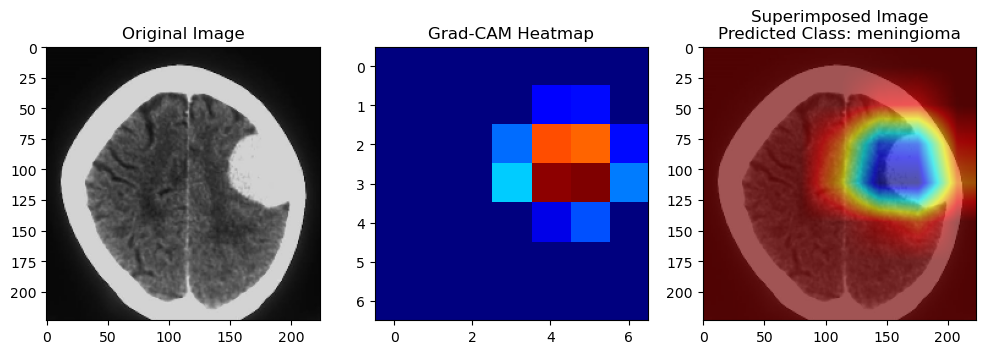

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

def get_gradcam(image, model, class_idx, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def superimpose_image(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img

def visualize_gradcam(image_path, model, labels, target_layer_name):
    image_size = (224, 224)
    
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load the image.")
        return
    image = cv2.resize(image, image_size)
    image = np.expand_dims(image, axis=0)
    
    # Predict the class of the image
    class_predictions = model.predict(image)
    predicted_class_idx = np.argmax(class_predictions)
    predicted_class_name = labels[predicted_class_idx]
    
    # Generate Grad-CAM
    heatmap = get_gradcam(image, model, predicted_class_idx, target_layer_name)
    
    # Superimpose heatmap on the original image
    superimposed_image = superimpose_image(image[0], heatmap)
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.imshow(image[0])
    plt.title('Original Image')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.subplot(133)
    plt.imshow(superimposed_image)
    plt.title('Superimposed Image\nPredicted Class: {}'.format(predicted_class_name))
    plt.show()

def main():
    # Define labels and other parameters
    labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
    target_layer_name = 'top_conv'
    
    # Path to the specific image
    specific_image_path = 'Tumor1/Testing/meningioma/Te-meTr_0009.jpg'
    
    # Load your model
    model = tf.keras.models.load_model('effmodel.h5')
    
    # Visualize Grad-CAM
    visualize_gradcam(specific_image_path, model, labels, target_layer_name)

if __name__ == "__main__":
    main()


In [21]:
import io
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import FileUpload, Button, Output, VBox
from IPython.display import display, clear_output
from tensorflow.keras.models import load_model, Model

# Constants
SPECIFIC_TARGET_LAYER_NAME = 'block14_sepconv2_act'  # Fill in the correct layer name
LABELS = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']  # List of class labels

def get_gradcam(image, model, class_idx, layer_name):
    # Get the output tensor of the specific layer
    layer_output = model.get_layer(layer_name).output

    # Create a model that outputs the layer's activations and the model's predictions
    grad_model = Model(inputs=model.input, outputs=[layer_output, model.output])

    # Calculate the gradient of the predicted class with respect to the output feature map
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def superimpose_image(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img

def visualize_images(original_img, heatmap, superimposed_img, predicted_class_name):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(131)
    plt.imshow(original_img)
    plt.title('Original Image')
    
    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    
    plt.subplot(133)
    plt.imshow(superimposed_img)
    plt.title(f'Superimposed Image\nPredicted Class: {predicted_class_name}')
    
    plt.tight_layout()
    plt.show()

def process_uploaded_images(upload):
    for file_info in upload:
        img = Image.open(io.BytesIO(file_info['content']))
        opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = cv2.resize(opencvImage, (224, 224))
        img = img.reshape(1, 224, 224, 3)

        # Predict the class of the image
        p = model.predict(img)
        p = np.argmax(p, axis=1)[0]
        predicted_class_name = LABELS[p]

        # Generate Grad-CAM
        heatmap = get_gradcam(img, model, p, SPECIFIC_TARGET_LAYER_NAME)
        superimposed_image = superimpose_image(img[0], heatmap)

        # Display the original image, Grad-CAM heatmap, and superimposed image
        with out:
            clear_output(wait=True)
            visualize_images(img[0], heatmap, superimposed_image, predicted_class_name)

def on_button_clicked(_):
    with out:
        clear_output(wait=True)
        if uploader.value:
            process_uploaded_images(uploader.value)
        else:
            print('No Image Uploaded')

# Load the trained model
model = load_model('Xception(99%).h5')  # Replace with the correct path to your model file

# Create the widgets
uploader = FileUpload()
button = Button(description='Predict and Visualize')
out = Output()

# Link the button click event to the function
button.on_click(on_button_clicked)

# Display the widgets
widgets_box = VBox([uploader, button, out])
display(widgets_box)


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

2023-09-01 06:48:05.408665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 13s 246ms/step


2023-09-01 06:48:21.188538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 9s 168ms/step - loss: 0.0139 - accuracy: 0.9950
Test Loss: 0.0139, Test Accuracy: 0.9950
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      0.99      0.99       306
 neurocytoma       1.00      1.00      1.00       153
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300
  schwannoma       0.98      1.00      0.99       130

    accuracy                           0.99      1594
   macro avg       0.99      1.00      0.99      1594
weighted avg       0.99      0.99      0.99      1594

[[298   2   0   0   0   0]
 [  0 302   0   1   1   2]
 [  0   0 153   0   0   0]
 [  0   0   0 405   0   0]
 [  1   1   0   0 298   0]
 [  0   0   0   0   0 130]]


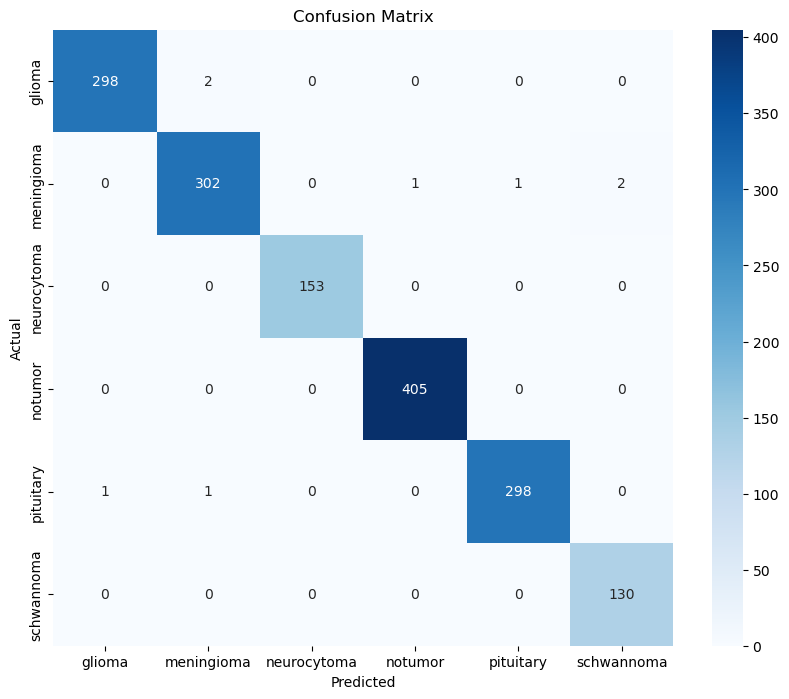

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model, save_model
model = load_model('Xception(99%).h5')
# Load and preprocess test images
test_folder = '/Users/abi/Desktop/Final/Tumor1/Testing'  # Update with your test image directory
test_labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
image_size = 224  # Set your desired image size
num_classes = len(test_labels)

X_test = []
y_test = []

for i in test_labels:
    folderPath = os.path.join(test_folder, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (224, 224))
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Convert labels to one-hot encoded format
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

# Perform inference on test images
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_test_labels = label_encoder.inverse_transform(y_pred_classes_test)
y_test_original = label_encoder.inverse_transform(y_test_encoded.argmax(axis=1))

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print classification report and confusion matrix
print(classification_report(y_test_original, y_pred_classes_test_labels, target_names=test_labels))
conf_matrix_test = confusion_matrix(y_test_original, y_pred_classes_test_labels)
print(conf_matrix_test)

# Display confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels, yticklabels=test_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
